In [1]:
# 1. Set up Kaggle API (upload kaggle.json as described earlier)
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 2. Download the dataset from Kaggle
!kaggle competitions download -c histopathologic-cancer-detection

# 3. Unzip the dataset
!unzip histopathologic-cancer-detection.zip -d /content/histopathologic-cancer-detection/

# 4. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 5. Create a directory in Google Drive
!mkdir -p /content/drive/My\ Drive/histopathologic_cancer_detection

# 6. Move the dataset to Google Drive
!cp -r /content/histopathologic-cancer-detection/ /content/drive/My\ Drive/histopathologic_cancer_detection/

# 7. Verify that the dataset is in Google Drive
!ls /content/drive/My\ Drive/histopathologic_cancer_detection/


Streaming output truncated to the last 5000 lines.
  inflating: /content/histopathologic-cancer-detection/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: /content/histopathologic-cancer-detection/train/fa2eaf8ec6267fa928a88775

#Setup Environment

In [17]:
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

#Load and Preprocess Data

In [7]:
data_dir = '/content/histopathologic-cancer-detection'

labels_df = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))

labels_df['file_path'] = labels_df['id'].apply(lambda x: os.path.join(data_dir, 'train', f'{x}.tif'))

labels_df['label'] = labels_df['label'].astype(str)

train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


#CNN Model

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

#Training

In [11]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=5500,
    validation_steps=1375,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20
5498/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8418 - loss: 0.3706
Epoch 1: val_accuracy improved from -inf to 0.79023, saving model to best_model.keras
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 832s 151ms/step - accuracy: 0.8418 - loss: 0.3706 - val_accuracy: 0.7902 - val_loss: 0.4956
Epoch 2/20
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 1:18 14ms/step - accuracy: 0.7812 - loss: 0.3408
Epoch 2: val_accuracy improved from 0.79023 to 1.00000, saving model to best_model.keras
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.7812 - loss: 0.3408 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 3/20
5498/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8583 - loss: 0.3359
Epoch 3: val_accuracy did not improve from 1.00000
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 794s 139ms/step - accuracy: 0.8583 - loss: 0.3359 - val_accuracy: 0.8636 - val_loss: 0.3168
Epoch 4/20
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 1:31 17ms/step - accuracy: 0.8125 - loss: 0.3161
Epoch 4: val_accuracy did not improve from 1.0

#Evaluate

In [13]:
model.load_weights('best_model.keras')

val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.8064 - loss: 0.4589
Validation Accuracy: 80.42%


#Plots for data visualisation

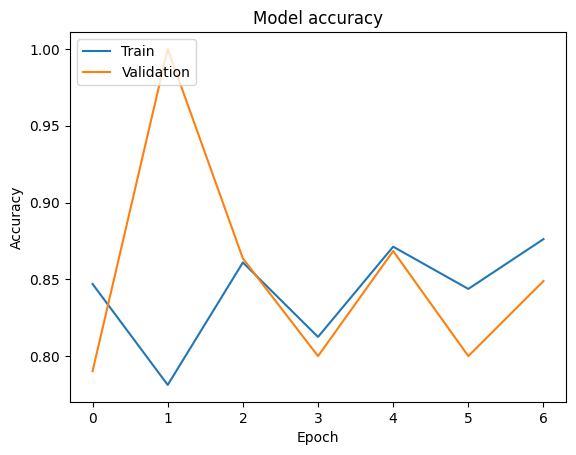

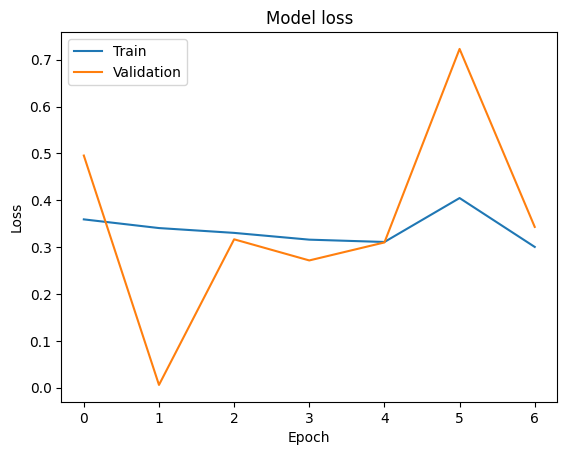

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Use test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


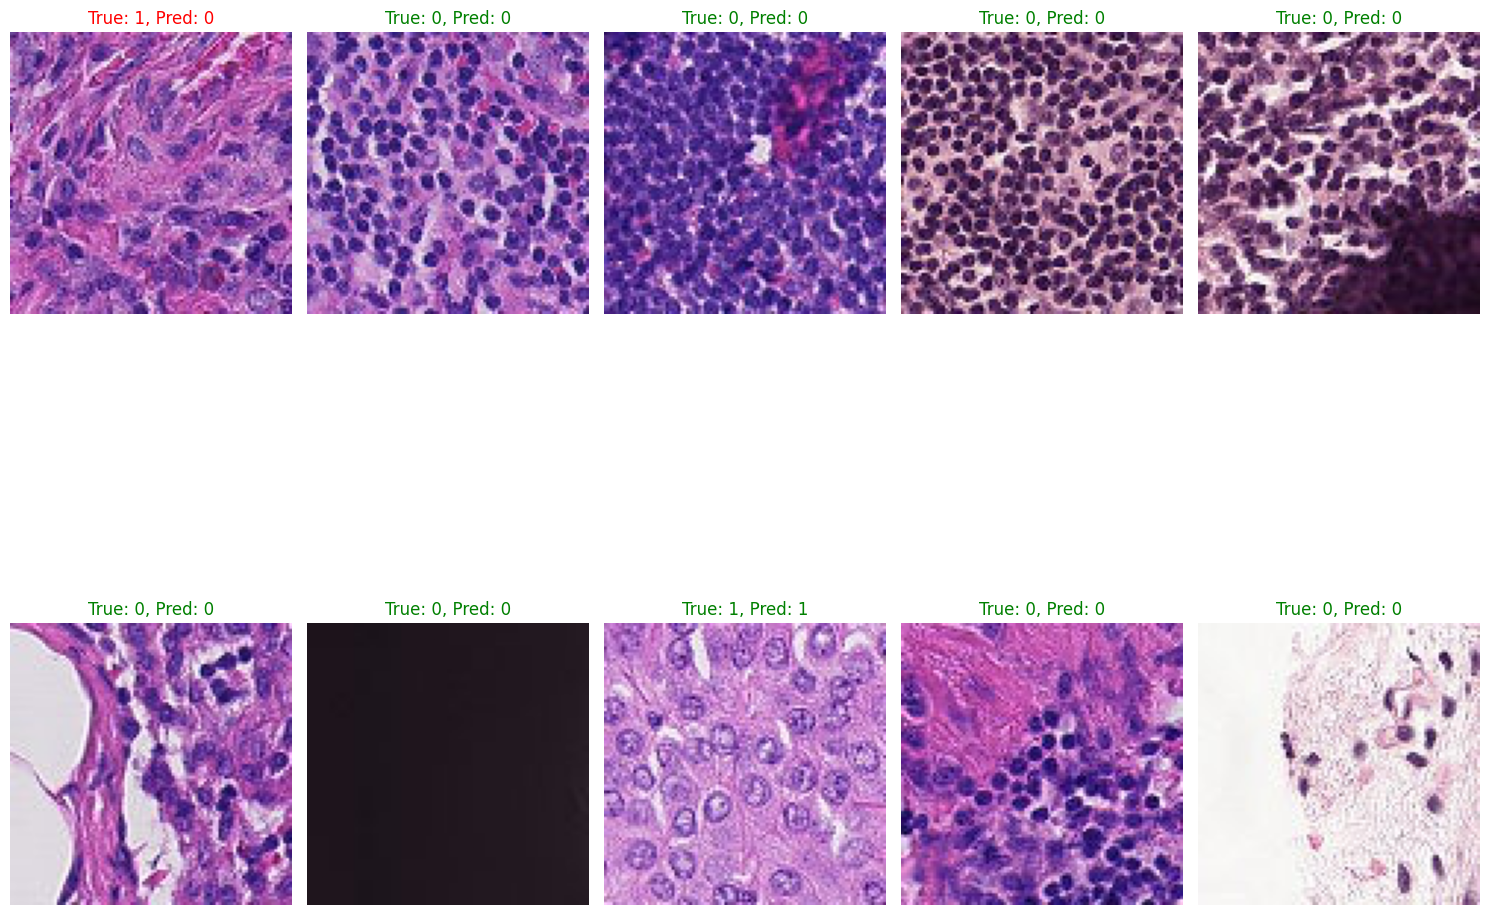

Correct Predictions: 9/10
Wrong Predictions: 1/10
Accuracy: 90.00%


In [31]:
sample_generator = next(val_generator)
sample_images, sample_labels = sample_generator[0][:10], sample_generator[1][:10]

predictions = model.predict(sample_images)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

correct_predictions = predicted_labels == sample_labels
num_correct = np.sum(correct_predictions)
num_total = len(sample_labels)
accuracy = num_correct / num_total

plt.figure(figsize=(15, 15))
for i in range(len(sample_images)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])

    color = 'green' if correct_predictions[i] else 'red'
    plt.title(f"True: {int(sample_labels[i])}, Pred: {predicted_labels[i]}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Correct Predictions: {num_correct}/{num_total}")
print(f"Wrong Predictions: {num_total - num_correct}/{num_total}")
print(f"Accuracy: {accuracy * 100:.2f}%")

#Save model

In [24]:
model.save('/content/drive/My Drive/histopathologic_cancer_detection/model.keras')